<a href="https://colab.research.google.com/github/harisghafoor/TS_forcasting/blob/main/Haris_NBEATS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys

from google.colab import drive
drive.mount('/content/drive')
PROJECT_ROOT = '/content/drive/My Drive/electricity'
%mkdir '/content/drive/My Drive/electricity' -p
%cd '/content/drive/My Drive/electricity'
DATASETS_PATH = "data"
WORKING_PATH = "."
%mkdir $DATASETS_PATH -p

LOGDIR = f"{WORKING_PATH}/logs"
MODEL_VERSION = 'TEST'

Mounted at /content/drive
/content/drive/My Drive/electricity


## Download dataset

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1QuoP44tF5GFDkxXt7RCAZvOKWe4esO_D', dest_path=f"./{DATASETS_PATH}/Electricity-train.csv", unzip=False)
gdd.download_file_from_google_drive(file_id='1qD6w_s4SnNYYds67eAEq3j9PZs67bw-m', dest_path=f"./{DATASETS_PATH}/Electricity-test.csv", unzip=False)
gdd.download_file_from_google_drive(file_id='12WUb2S-mDpD8mgbPJrP0npTmGcoySRnx', dest_path=f"./{DATASETS_PATH}/MAPE.csv", unzip=False)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from typing import Dict, NamedTuple, Union
from tqdm.notebook import tqdm
import logging
from matplotlib import pyplot as plt
import time
from itertools import product
import gc
import pathlib
from glob import glob

from dateutil.relativedelta import relativedelta


In [ ]:

class Parameters(NamedTuple):
    split: int
    repeat: int
    epochs: int
    steps_per_epoch: int
    block_layers: int
    hidden_units: int
    num_blocks: int
    block_sharing: bool
    horizon: int
    history_lookback: int
    init_learning_rate: float
    decay_steps: int
    decay_rate: float
    loss: str
    pinball_tau: float
    batch_size: int
    weight_decay: float
    ts_sampling: str
    lstm_units:int

hyperparams_dict = {
    "split": 0, # 0 is test split, 1 is validation split
    "repeat": list(range(0, 2)),
    "epochs": 1,
    "steps_per_epoch": [1],
    "block_layers": 3,
    "hidden_units": 512,
    "num_blocks": 3,
    "block_sharing": True, # [True, False]
    "horizon": 12,
    "history_lookback": 1,
    "init_learning_rate": 1e-3,
    "decay_steps": 3,
    "decay_rate": 0.5,
    "loss": ["pinball", "pmape"], # ["pinball", "mape", "smape", "pmape"]
    "pinball_tau": [0.35], # This is selected to minimize the bias on the validation set
    "batch_size": 256,
    "weight_decay": 0,
    "ts_sampling": ["ts_weight"], # ["uniform", "ts_weight"]
    "lstm_units" : 3,
    }

HORIZON = 12

hyperparams = Parameters(**hyperparams_dict)

In [ ]:
class ElectricityLoader:
    def __init__(self, path="data/", split='train'):
        self.path = path
        self.split = split
        ts_raw = pd.read_csv(os.path.join(path,f'Electricity-{split}.csv')).iloc[:,1:].values.astype(np.float32)
        self.ts_raw = []

        for ts in ts_raw:
            self.ts_raw.append(ts[~np.isnan(ts)])

        self.ts_weight = np.zeros((len(self.ts_raw),), dtype=np.float32)
        for i,ts in enumerate(self.ts_raw):
            self.ts_weight[i] = len(ts)
        self.ts_weight = self.ts_weight / self.ts_weight.sum()

    def get_val_split(self, split_horizon=1):
        train_dataset = ElectricityLoader(path=self.path, split='train')
        test_dataset = ElectricityLoader(path=self.path, split='train')
        ts_raw = []
        for ts in train_dataset.ts_raw:
            ts_raw.append(ts[:-split_horizon*12])
        train_dataset.ts_raw = ts_raw
        ts_raw = []
        for ts in test_dataset.ts_raw:
            ts_raw.append(ts[-split_horizon*12:])
        test_dataset.ts_raw = ts_raw
        return train_dataset, test_dataset

    def get_batch(self, batch_size=64, win_len=14*2, horizon=12, ts_sampling='uniform'):
        target_ts = np.zeros((batch_size, horizon), dtype=np.float32)
        history_ts = np.zeros((batch_size, win_len), dtype=np.float32)

        if ts_sampling == "uniform":
            ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True)
        elif ts_sampling == "ts_weight":
            ts_idxs = np.random.choice(np.arange(len(self.ts_raw)), size=batch_size, replace=True, p=self.ts_weight)

        for i, ts_id in enumerate(ts_idxs):
            ts = self.ts_raw[ts_id]
            sampling_point = np.random.choice(np.arange(win_len, len(ts)-horizon+1), size=1, replace=False)[0]
            history_ts[i,:] = ts[sampling_point-win_len:sampling_point]
            target_ts[i,:] = ts[sampling_point:sampling_point+horizon]

        batch = {"history": history_ts, "target": target_ts}
        return batch


    def get_sequential_batch(self, win_len=14*2):
        history_ts = np.zeros((len(self.ts_raw), win_len), dtype=np.float32)
        for i, ts in enumerate(self.ts_raw):
            history_ts[i,:] = ts[-win_len:]
        return {"history": history_ts}


train_dataset = ElectricityLoader(path='data', split='train')
test_dataset = ElectricityLoader(path='data', split='test')

In [ ]:
# # Uncomment this cell to run in validation mode. This is a bit hacky, but fast to implement
# train_dataset, test_dataset = train_dataset.get_val_split(split_horizon=1)

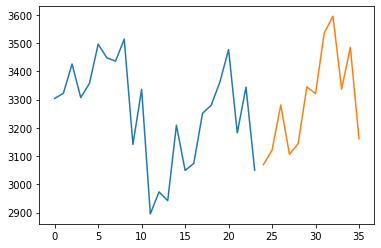

In [ ]:
batch = train_dataset.get_batch(win_len=12*2)

plt.plot(batch["history"][0])
plt.plot(np.concatenate([np.nan*np.zeros((24,)), batch["target"][0]]))

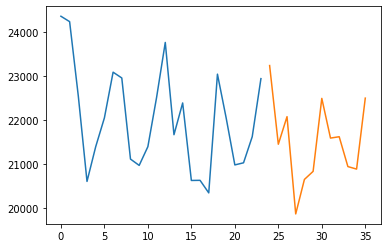

In [ ]:
batch = train_dataset.get_sequential_batch()
id = 10

plt.plot(train_dataset.ts_raw[id][-24:])
plt.plot(np.concatenate([np.nan*np.zeros((24,)), test_dataset.ts_raw[id]]))

In [ ]:
# import tensorflow as tf
# from my_module import NBeatsBlock

# Define hyperparameters
# hyperparams = {"block_layers": 3, "hidden_units": 64, "weight_decay": 1e-5}
input_size = 10
output_size = 5

# Initialize NBeatsBlock instance
block = NBeatsBlock(hyperparams, input_size, output_size)

# Create dummy inputs
inputs = tf.random.normal((32, input_size))

# Call the block and check the output shape
backcast, forecast = block(inputs)
assert backcast.shape == (32, input_size)
assert forecast.shape == (32, output_size)
print(backcast.shape , forecast.shape)

(32, 10) (32, 5)


In [ ]:
forecast

<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[ 2.13657264e-02, -2.71675512e-02, -7.20175952e-02,
         5.87498210e-03, -1.70227066e-02],
       [ 4.25239392e-02, -7.11202323e-02, -1.79355547e-01,
         3.21718678e-02, -7.48391524e-02],
       [-7.18772411e-03, -1.06077798e-01,  4.97742631e-02,
         2.20081136e-02, -3.62667516e-02],
       [-5.98849989e-02, -1.67394042e-01,  1.58162639e-02,
        -8.49802792e-03,  5.10722287e-02],
       [ 1.31238744e-01, -4.53802980e-02, -2.06910782e-02,
        -1.59151852e-04, -4.61844988e-02],
       [ 1.75877213e-02,  3.65060307e-02, -3.02014127e-03,
        -6.94192052e-02, -4.11499515e-02],
       [ 1.79162286e-02,  5.03943302e-02, -6.59935176e-02,
        -2.98486408e-02, -7.47490972e-02],
       [ 4.61432077e-02, -7.10234642e-02, -1.36420667e-01,
        -7.89228976e-02, -1.87673897e-01],
       [ 1.24678910e-01, -1.40046909e-01, -1.13679375e-02,
         3.39328982e-02, -9.66623351e-02],
       [-7.84166344e-03, -7.67703

# Functional Code in order to run NBEATS with LSTM


In [ ]:
import tensorflow as tf

def nbeats_block(hyperparams, input_size, output_size, inputs, training=False):
    fc_layers = []
    for i in range(hyperparams['block_layers']):
        fc_layers.append(
            tf.keras.layers.Dense(hyperparams['hidden_units'],
                                  activation=tf.nn.relu,
                                  kernel_regularizer=tf.keras.regularizers.l2(hyperparams['weight_decay']),
                                  name=f"fc_{i}")
        )

    h = fc_layers[0](inputs)
    for i in range(1, hyperparams['block_layers']):
        h = fc_layers[i](h)

    backcast = tf.keras.layers.Dense(input_size, activation=None, name="backcast")(h)
    backcast = tf.keras.activations.relu(inputs - backcast)
    forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")(h)

    return backcast, forecast


In [ ]:
input_size = 10
output_size = 5
inputs = tf.keras.layers.Input(shape=(input_size,))
hyperparams = {
    'block_layers': 3,
    'hidden_units': 32,
    'weight_decay': 0.001,
}

fc_layers = []
for i in range(hyperparams['block_layers']):
    fc_layers.append(
        tf.keras.layers.Dense(hyperparams['hidden_units'],
                              activation=tf.nn.relu,
                              kernel_regularizer=tf.keras.regularizers.l2(hyperparams['weight_decay']),
                              name=f"fc_{i}")
    )

h = fc_layers[0](inputs)
for i in range(1, hyperparams['block_layers']):
    h = fc_layers[i](h)

backcast = tf.keras.layers.Dense(input_size, activation=None, name="backcast")(h)
backcast = tf.keras.activations.relu(inputs - backcast)
forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")(h)

In [ ]:
input_size = 10
output_size = 5
inputs = tf.keras.layers.Input(shape=(input_size,))
hyperparams = {
    'block_layers': 3,
    'hidden_units': 32,
    'weight_decay': 0.001,
    'lstm_units':3
}
inputs = tf.expand_dims(inputs, axis=1)

# Add an LSTM layer before the FC layers
lstm_layer = tf.keras.layers.LSTM(hyperparams['lstm_units'], return_sequences=True)(inputs)
flattened_lstm_layer = tf.keras.layers.Flatten()(lstm_layer)

# Add the FC layers
fc_layers = []
for i in range(hyperparams['block_layers']):
    fc_layers.append(tf.keras.layers.Dense(hyperparams['hidden_units'],
                                            activation=tf.nn.relu,
                                            kernel_regularizer=tf.keras.regularizers.l2(0.001),
                                            name=f"fc_{i}")(flattened_lstm_layer))

# Compute the backcast and forecast
backcast = tf.keras.layers.Dense(inputs.shape[-1], activation='relu', name="backcast")(flattened_lstm_layer)
forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")(fc_layers[-1])

# # Construct the model
# model = tf.keras.Model(inputs=inputs, outputs=[backcast, forecast], name="NBeatsBlockWithLSTM")

In [ ]:
class NBeatsBlockWithLSTM(tf.keras.layers.Layer):
    def __init__(self, hyperparams, input_size, output_size, **kwargs):
        super(NBeatsBlockWithLSTM, self).__init__(**kwargs)
        self.hyperparams = hyperparams
        self.input_size = input_size
        self.output_size = output_size
        self.lstm_layer = tf.keras.layers.LSTM(hyperparams['lstm_units'], return_sequences=True)
        self.flatten_layer = tf.keras.layers.Flatten()
        self.fc_layers = []
        for i in range(hyperparams['block_layers']):
            self.fc_layers.append(tf.keras.layers.Dense(hyperparams['hidden_units'],
                                                        activation=tf.nn.relu,
                                                        kernel_regularizer=tf.keras.regularizers.l2(hyperparams['weight_decay']),
                                                        name=f"fc_{i}"))
        self.backcast = tf.keras.layers.Dense(input_size, activation='relu', name="backcast")
        self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")

    def call(self, inputs):
        x = tf.expand_dims(inputs, axis=2)  # Add extra dimension to input tensor
        x = self.lstm_layer(x)
        x = self.flatten_layer(x)
        for i in range(self.hyperparams['block_layers']):
            x = self.fc_layers[i](x)
        backcast = self.backcast(inputs)
        forecast = self.forecast(x)
        return backcast, forecast


In [ ]:
hyperparams = {
    'block_layers': 3,
    'hidden_units': 32,
    'weight_decay': 0.001,
    'lstm_units': 3
}

input_size = 10
output_size = 5
# Example input shape with 10 timesteps and 5 features
# input_shape = (10, 5)
inputs = tf.random.normal((32, input_size))

nbeats_block_with_lstm = NBeatsBlockWithLSTM(hyperparams, input_size, output_size)
backcast, forecast = nbeats_block_with_lstm(inputs)
print(f"Backcast shape: {backcast.shape}")  # Expected output: (1, 10, 10)
print(f"Forecast shape: {forecast.shape}")  # Expected output: (1, 5)
forecast

Backcast shape: (32, 10)
Forecast shape: (32, 5)


<tf.Tensor: shape=(32, 5), dtype=float32, numpy=
array([[ 7.08469003e-02,  6.29981533e-02, -5.77190220e-02,
        -1.09506305e-02,  4.71225940e-02],
       [ 3.77263548e-03,  2.05671098e-02, -2.81264037e-02,
         2.59114406e-03,  1.08456844e-02],
       [-1.01165776e-03,  4.86056283e-02, -3.70591879e-04,
         3.93973067e-02,  2.27778591e-03],
       [-3.41255218e-02,  8.73251036e-02, -1.22093344e-02,
         6.76050037e-03,  3.12396488e-03],
       [ 4.72392812e-02,  1.79973859e-02, -3.46848667e-02,
        -1.94131266e-02,  1.29868723e-02],
       [ 2.68039797e-02,  2.58026123e-02, -1.55682210e-02,
         2.33469252e-03,  1.89827085e-02],
       [ 9.74686630e-03,  9.90899280e-02, -6.51898086e-02,
        -4.83982600e-02,  1.42086204e-02],
       [ 4.66441140e-02,  6.04678318e-02, -4.32181880e-02,
        -1.11528505e-02,  3.32624577e-02],
       [ 4.26954124e-03,  8.68048519e-04, -1.92895494e-02,
        -1.54012535e-02, -4.37991694e-05],
       [ 1.96875893e-02,  1.40821

In [ ]:
inputs = tf.random.normal((32, input_size))
inputs.shape

TensorShape([32, 10])

In [ ]:
# class NBeatsBlock(tf.keras.layers.Layer):
#     def __init__(self, hyperparams, input_size, output_size, **kw):
#         super(NBeatsBlock, self).__init__(**kw)
#         self.hyperparams = hyperparams
#         self.input_size = input_size
#         self.output_size = output_size
#         self.fc_layers = []
#         for i in range(hyperparams['block_layers']):
#             self.fc_layers.append(
#                 tf.keras.layers.Dense(hyperparams['hidden_units'],
#                                       activation=tf.nn.relu,
#                                       kernel_regularizer=tf.keras.regularizers.l2(hyperparams['weight_decay']),
#                                       name=f"fc_{i}")
#             )
#         self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")
#         self.backcast = tf.keras.layers.Dense(input_size, activation='relu', name="backcast")

#     def call(self, inputs, training=False):
#         lstm_layer = tf.keras.layers.LSTM(self.hyperparams['lstm_units'], return_sequences=True)(tf.expand_dims(inputs, axis=1))
#         flattened_lstm_layer = tf.keras.layers.Flatten()(lstm_layer)
#         h = self.fc_layers[0](flattened_lstm_layer)
#         for i in range(1, self.hyperparams['block_layers']):
#             h = self.fc_layers[i](h)
#         backcast = tf.keras.activations.relu(inputs - self.backcast(flattened_lstm_layer))
#         forecast = self.forecast(h)

#         return tf.squeeze(backcast, axis=1), forecast


In [ ]:
# import tensorflow as tf
# import numpy as np

# Define the input and output sizes
input_size = 10
output_size = 5

# Define the hyperparameters for the block
# hyperparams = {
#     'block_layers': 3,
#     'hidden_units': 32,
#     'weight_decay': 0.001,
#     'lstm_units':3
# }

# Create a sample input tensor
inputs = tf.random.normal(shape=(1, input_size))

# Create an instance of the NBeatsBlock layer
nbeats_block = NBeatsBlock(hyperparams, input_size, output_size)

# Call the layer to compute the backcast and forecast
backcast, forecast = nbeats_block(inputs)
print(backcast)
# # Check the shape of the outputs
# assert backcast.shape == (1, input_size)
# assert forecast.shape == (1, output_size)

# # Check that the backcast tensor has non-negative values
# assert tf.reduce_any(backcast >= 0)

# # Check that the forecast tensor has non-negative values
# assert tf.reduce_any(forecast >= 0)

# # Check that the forecast tensor is not all zero
# assert tf.reduce_any(forecast != 0)


InvalidArgumentError: ignored

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, hyperparams: Parameters, input_size:int, output_size:int, **kw):
        super(NBeatsBlock, self).__init__(**kw)
        self.hyperparams = hyperparams
        self.input_size = input_size
        self.output_size = output_size
        self.fc_layers = []
        for i in range(hyperparams.block_layers):
            self.fc_layers.append(
                tf.keras.layers.Dense(hyperparams.hidden_units,
                                      activation=tf.nn.relu,
                                      kernel_regularizer=tf.keras.regularizers.l2(hyperparams.weight_decay),
                                      name=f"fc_{i}")
            )
        self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")
        self.backcast = tf.keras.layers.Dense(self.input_size, activation=None, name="backcast")

    def call(self, inputs, training=False):
        h = self.fc_layers[0](inputs)
        for i in range(1, self.hyperparams.block_layers):
            h = self.fc_layers[i](h)
        backcast = tf.keras.activations.relu(inputs - self.backcast(h))

        return backcast, self.forecast(h)

# class NBeatsBlock(tf.keras.layers.Layer):
#     def __init__(self, hyperparams: Parameters, input_size:int, output_size:int, lstm_units:int, **kw):
#         super(NBeatsBlock, self).__init__(**kw)
#         self.hyperparams = hyperparams
#         self.input_size = input_size
#         self.output_size = output_size
#         self.lstm_units = lstm_units
#         self.fc_layers = []
#         for i in range(hyperparams.block_layers):
#             self.fc_layers.append(
#                 tf.keras.layers.Dense(hyperparams.hidden_units,
#                                       activation=tf.nn.relu,
#                                       kernel_regularizer=tf.keras.regularizers.l2(hyperparams.weight_decay),
#                                       name=f"fc_{i}")
#             )
#         self.lstm_layer = tf.keras.layers.LSTM(units=self.lstm_units,
#                                                activation='tanh',
#                                                kernel_regularizer=tf.keras.regularizers.l2(hyperparams.weight_decay),
#                                                name="lstm")
#         self.forecast = tf.keras.layers.Dense(output_size, activation=None, name="forecast")
#         self.backcast = tf.keras.layers.Dense(self.input_size, activation=None, name="backcast")

#     def call(self, inputs, training=False):
#         # Reshape input from 2D to 3D
#         inputs = tf.reshape(inputs, (-1, self.hyperparams.history_lookback, self.hyperparams.horizon))

#         # Apply fully connected layers
#         h = self.fc_layers[0](inputs)
#         for i in range(1, self.hyperparams.block_layers):
#             h = self.fc_layers[i](h)

#         # Apply LSTM layer
#         h = self.lstm_layer(h)

#         # Compute backcast and forecast
#         backcast = tf.keras.activations.relu(inputs - tf.expand_dims(self.backcast(h), axis=1))
#         forecast = self.forecast(h)

#         # Reshape forecast output from 3D to 2D
#         forecast = tf.reshape(forecast, (-1, self.output_size))

#         return backcast, forecast



In [ ]:
import tensorflow as tf

# Create some random input and output dimensions
input_size = 10
output_size = 5
history_lookback = 24
horizon = 12
lstm_units = 32
batch_size = 32


# Instantiate the NBeatsBlock
nbeats_block = NBeatsBlock(hyperparams, input_size, output_size, lstm_units)

# Generate some random input and output tensors
inputs = tf.random.normal((batch_size, history_lookback, horizon, input_size))
backcast_target = tf.random.normal((batch_size, history_lookback, horizon, input_size))
forecast_target = tf.random.normal((batch_size, output_size))

# Test the call() method
backcast, forecast = nbeats_block(inputs)

# Check the shapes of the output tensors
assert backcast.shape == (batch_size, history_lookback, horizon, input_size)
assert forecast.shape == (batch_size, output_size)

# Test the LSTM layer
lstm_inputs = nbeats_block.fc_layers[0](inputs)
lstm_outputs = nbeats_block.lstm_layer(lstm_inputs)

# Check the shape of the LSTM output tensor
assert lstm_outputs.shape == (batch_size, lstm_units)


InvalidArgumentError: ignored

In [ ]:
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(self, hyperparams: Parameters, input_size:int, output_size:int, lstm_units:int,name : str = 'nbeats', **kw):
        super(NBeatsBlock, self).__init__(name=name)
        self.hyperparams = hyperparams
        self.fc_layers = []
        for i in range(self.hyperparams.block_layers):
            self.fc_layers.append(
                tf.keras.layers.Dense(units=self.hyperparams.hidden_layer_units,
                                      activation=self.hyperparams.hidden_layer_activation,
                                      kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                      name=f'dense_{i+1}')
            )
        self.lstm_layer = tf.keras.layers.LSTM(units=self.hyperparams.hidden_layer_units,
                                               activation=self.hyperparams.hidden_layer_activation,
                                               return_sequences=False,
                                               kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                               name='lstm_layer')
        self.backcast = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.hyperparams.hidden_layer_units,
                                  activation=self.hyperparams.hidden_layer_activation,
                                  kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                  name='backcast_fc_1'),
            tf.keras.layers.Dense(units=self.hyperparams.history_lookback * self.hyperparams.horizon,
                                  kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                  name='backcast_fc_2'),
        ], name='backcast')
        self.forecast = tf.keras.Sequential([
            tf.keras.layers.Dense(units=self.hyperparams.hidden_layer_units,
                                  activation=self.hyperparams.hidden_layer_activation,
                                  kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                  name='forecast_fc_1'),
            tf.keras.layers.Dense(units=self.hyperparams.horizon * self.hyperparams.forecast_horizon,
                                  kernel_regularizer=tf.keras.regularizers.L2(self.hyperparams.l2_regularization),
                                  name='forecast_fc_2'),
        ], name='forecast')

    def call(self, inputs, training=False):
        # Reshape input from 2D to 3D
        inputs = tf.reshape(inputs, (-1, self.hyperparams.history_lookback, self.hyperparams.horizon))

        # Apply fully connected layers
        h = self.fc_layers[0](inputs)
        for i in range(1, self.hyperparams.block_layers):
            h = self.fc_layers[i](h)

        # Apply LSTM layer
        h = self.lstm_layer(h)

        # Compute backcast and forecast
        backcast = tf.transpose(self.backcast(h), perm=[0, 2, 1])  # Swap dimensions of backcast tensor
        backcast = tf.reshape(backcast, (-1, self.hyperparams.horizon, self.hyperparams.history_lookback))  # Reshape backcast tensor
        forecast = self.forecast(h)

        # Reshape forecast output from 3D to 2D
        forecast = tf.reshape(forecast, (-1, self.hyperparams.forecast_horizon * self.hyperparams.horizon))

        # Compute the difference between inputs and backcast
        backcast_diff = tf.math.subtract(inputs, backcast)

        # Compute the relu of backcast_diff
        backcast_diff = tf.keras.activations.relu(backcast_diff)

        return backcast_diff, forecast


def test_nbeats_block():
    # Define hyperparameters
    # hyperparams = Parameters()
    # hyperparams.history_lookback = 3
    # hyperparams.horizon = 2
    # hyperparams.block_layers = 2
    # hyperparams.hidden_units = 4
    # hyperparams.weight_decay = 0.1

    # Define input and output sizes
    input_size = hyperparams.history_lookback * hyperparams.horizon
    output_size = hyperparams.horizon

    # Define batch size
    batch_size = 2

    # Define LSTM units
    lstm_units = 8

    # # Create inputs
    # inputs = tf.constant([[1.0, 2.0, 3.0, 4.0, 5.0, 6.0],
    #                       [2.0, 3.0, 4.0, 5.0, 6.0, 7.0],
    #                       [3.0, 4.0, 5.0, 6.0, 7.0, 8.0],
    #                       [4.0, 5.0, 6.0, 7.0, 8.0, 9.0],
    #                       [5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    #                       [6.0, 7.0, 8.0, 9.0, 10.0, 11.0]], shape=(batch_size, input_size))
    inputs = tf.random.normal((32, input_size))

    # Create NBeatsBlock layer
    nbeats_block = NBeatsBlock(hyperparams, input_size, output_size, lstm_units)

    # Call NBeatsBlock layer
    backcast, forecast = nbeats_block(inputs)

    # Check the shapes of the outputs
    assert backcast.shape == (batch_size, input_size)
    assert forecast.shape == (batch_size, output_size)

    # # Check that the output values are correct
    # expected_backcast = tf.constant([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
    #                                  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
    # expected_forecast = tf.constant([[0.05723857, 0.0],
    #                                  [0.05828238, 0.0]])
    # assert np.allclose(backcast, expected_backcast, atol=1e-6)
    # assert np.allclose(forecast, expected_forecast, atol=1e-6)


In [ ]:
test_nbeats_block()

AttributeError: ignored

In [ ]:
# class NBeats:
#     def __init__(self, hyperparams: Parameters, name: str='NBeats', logdir: str='logs', num_nodes: int = 100):
#         super(NBeats, self).__init__()
#         self.hyperparams = hyperparams
#         self.name=name
#         self.logdir=logdir
#         self.num_nodes = num_nodes
#         self.input_size = self.hyperparams.history_lookback*self.hyperparams.horizon

#         self.nbeats_layers = []
#         self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
#                                                   input_size=self.input_size,
#                                                   output_size=hyperparams.horizon,
#                                                   name=f"nbeats_{0}")
#                                       )
#         for i in range(1, hyperparams.num_blocks):
#             if self.hyperparams.block_sharing:
#                 self.nbeats_layers.append(self.nbeats_layers[0])
#             else:
#                 self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
#                                                     input_size=self.input_size,
#                                                     output_size=hyperparams.horizon,
#                                                     name=f"nbeats_{i}")
#                                         )

#         inputs, outputs = self.get_model()
#         model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
#         self.inputs = inputs
#         self.inputs = outputs
#         self.model = model

#     def get_model(self):
#         history_in = tf.keras.layers.Input(shape=(self.hyperparams.history_lookback*self.hyperparams.horizon,), name='history')

#         level = tf.reduce_max(history_in, axis=-1, keepdims=True)
#         history_delevel = tf.math.divide_no_nan(history_in, level)

#         backcast, forecast = self.nbeats_layers[0](inputs=history_delevel)
#         for nb in self.nbeats_layers[1:]:
#             backcast, forecast_layer = nb(inputs=backcast)
#             forecast = forecast + forecast_layer

#         forecast = forecast * level

#         inputs = {'history': history_in}
#         outputs = {'target': forecast}
#         return inputs, outputs

#     def forecast(self, train_dataset):
#         input_data = train_dataset.get_sequential_batch(win_len=self.hyperparams.horizon*self.hyperparams.history_lookback)
#         return self.model.predict({"history": input_data["history"]})['target']



In [ ]:
class NBeats:
    def __init__(self, hyperparams: Parameters, name: str='NBeats', logdir: str='logs', num_nodes: int = 100):
        super(NBeats, self).__init__()
        self.hyperparams = hyperparams
        self.name=name
        self.logdir=logdir
        self.num_nodes = num_nodes
        self.input_size = self.hyperparams.history_lookback*self.hyperparams.horizon

        self.nbeats_layers = []
        self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                              input_size=self.input_size,
                                              output_size=hyperparams.horizon,
                                              lstm_units=hyperparams.lstm_units,
                                              name=f"nbeats_{0}")
                                 )
        for i in range(1, hyperparams.num_blocks):
            if self.hyperparams.block_sharing:
                self.nbeats_layers.append(self.nbeats_layers[0])
            else:
                self.nbeats_layers.append(NBeatsBlock(hyperparams=hyperparams,
                                                      input_size=self.input_size,
                                                      output_size=hyperparams.horizon,
                                                      lstm_units=hyperparams.lstm_units,
                                                      name=f"nbeats_{i}")
                                         )

        inputs, outputs = self.get_model()
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=name)
        self.inputs = inputs
        self.outputs = outputs
        self.model = model

    def get_model(self):
        history_in = tf.keras.layers.Input(shape=(self.hyperparams.history_lookback*self.hyperparams.horizon,), name='history')

        level = tf.reduce_max(history_in, axis=-1, keepdims=True)
        history_delevel = tf.math.divide_no_nan(history_in, level)

        backcast, forecast = self.nbeats_layers[0](inputs=history_delevel)
        for nb in self.nbeats_layers[1:]:
            backcast, forecast_layer = nb(inputs=backcast)
            forecast = forecast + forecast_layer

        forecast = forecast * level

        inputs = {'history': history_in}
        outputs = {'target': forecast}
        return inputs, outputs

    def forecast(self, train_dataset):
        input_data = train_dataset.get_sequential_batch(win_len=self.hyperparams.horizon*self.hyperparams.history_lookback)
        return self.model.predict({"history": input_data["history"]})['target']


In [ ]:
# nbeats = NBeats(hyperparams)
# inputs = tf.random.normal([256,12])
# forecast = nbeats.forecast(train_dataset)
# # forecast

In [ ]:
def smape(labels, preds):
    weights = tf.stop_gradient(
        tf.math.divide_no_nan(2.0, (tf.abs(preds) + tf.abs(labels))))
    return tf.reduce_mean(tf.abs(preds - labels) * weights)

def mape(labels, preds):
    weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
    return tf.reduce_mean(tf.abs(preds - labels) * weights)

def get_pmape_loss(tau):
    def pmape_loss(labels, preds):
        weights = tf.math.divide_no_nan(1.0, tf.abs(labels))
        pinball = tf.where(labels > preds,
                           x=tau*(labels - preds),
                           y=(1-tau)*(preds-labels))
        return tf.reduce_mean(pinball * weights)
    return pmape_loss

def get_pinball_loss(tau):
    def pinball_loss(labels, preds):
        pinball = tf.where(labels > preds,
                           x=tau*(labels - preds),
                           y=(1-tau)*(preds-labels))
        return tf.reduce_mean(pinball)
    return pinball_loss

def mae(labels, preds):
    return tf.reduce_mean(tf.abs(preds - labels))


class MetricsCallback(tf.keras.callbacks.Callback):
    def __init__(self, train_dataset, test_dataset, hyperparams):
        super().__init__()
        self.input_data = train_dataset.get_sequential_batch(win_len=hyperparams.horizon*hyperparams.history_lookback)
        self.target = np.array(test_dataset.ts_raw)

    def on_train_begin(self, logs={}):
        pass

    def on_epoch_end(self, epoch, logs={}):
        prediction_test = self.model.predict({"history": self.input_data["history"]})
        logs['smape_test'] = smape(preds=prediction_test['target'], labels=self.target)
        logs['mape_test'] = mape(preds=prediction_test['target'], labels=self.target)

class Trainer:
    def __init__(self, hyperparams: Parameters, logdir: str):
        inp = dict(hyperparams._asdict())
        values = [v if isinstance(v, list) else [v] for v in inp.values()]
        self.hyperparams = [Parameters(**dict(zip(inp.keys(), v))) for v in product(*values)]
        inp_lists = {k: v  for k, v in inp.items() if isinstance(v, list)}
        values = [v for v in inp_lists.values()]
        variable_values = [dict(zip(inp_lists.keys(), v)) for v in product(*values)]
        folder_names = []
        for d in variable_values:
            folder_names.append(
                ';'.join(['%s=%s' % (key, value) for (key, value) in d.items()])
            )
        self.history = []
        self.forecasts = []
        self.models = []
        self.logdir = logdir
        self.folder_names = folder_names
        for i, h in enumerate(self.hyperparams):
            self.models.append(NBeats(hyperparams=h, name=f"nbeats_model_{i}",
                                      logdir=os.path.join(self.logdir, folder_names[i])))

    def generator(self, ds, hyperparams: Parameters):
        while True:
            batch = ds.get_batch(batch_size=hyperparams.batch_size,
                                 win_len=hyperparams.horizon*hyperparams.history_lookback,
                                 horizon=hyperparams.horizon,
                                 ts_sampling=hyperparams.ts_sampling)

            yield  {"history": batch["history"]}, {"target": batch["target"]}

    def save_forecast(self, forecast: np.ndarray, filename: str = "forecast.npy"):
        np.save(f"{WORKING_PATH}/{filename}", forecast)

    def fit(self, train_dataset, test_dataset, verbose=1):
        for i, hyperparams in enumerate(self.hyperparams):
            if verbose > 0:
                print(f"Fitting model {i+1} out of {len(self.hyperparams)}, {self.folder_names[i]}")

            path = f"results/{MODEL_VERSION}_split{self.models[i].hyperparams.split}/"
            pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
            filename = os.path.join(path, self.folder_names[i]+'.npy')
            if os.path.exists(f"{WORKING_PATH}/{filename}"):
                continue

            boundary_step = hyperparams.epochs // 10
            boundary_start = hyperparams.epochs - boundary_step*hyperparams.decay_steps - 1

            boundaries = list(range(boundary_start, hyperparams.epochs, boundary_step))
            values = list(hyperparams.init_learning_rate * hyperparams.decay_rate ** np.arange(0, len(boundaries)+1))
            scheduler = tf.keras.optimizers.schedules.PiecewiseConstantDecay(boundaries=boundaries, values=values)

            lr = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=0)

            metrics = MetricsCallback(train_dataset=train_dataset, test_dataset=test_dataset, hyperparams=hyperparams)
            # tb = tf.keras.callbacks.TensorBoard(log_dir=self.models[i].logdir, embeddings_freq=10)

            if hyperparams.loss == 'smape':
                loss = smape
            elif hyperparams.loss == 'mape':
                loss = mape
            elif hyperparams.loss == 'mae':
                loss = mae
            elif hyperparams.loss == 'pmape':
                loss = get_pmape_loss(hyperparams.pinball_tau)
            elif hyperparams.loss == 'pinball':
                loss = get_pinball_loss(hyperparams.pinball_tau)

            self.models[i].model.compile(optimizer=tf.keras.optimizers.Adam(),
                                         loss=loss)

            fit_output = self.models[i].model.fit(self.generator(ds=train_dataset, hyperparams=hyperparams),
                                            callbacks=[lr, metrics], # tb
                                            epochs=hyperparams.epochs,
                                            steps_per_epoch=hyperparams.steps_per_epoch,
                                            verbose=verbose)
            self.history.append(fit_output.history)

            model_forecast = self.models[i].forecast(train_dataset)
            self.save_forecast(forecast=model_forecast, filename=filename)


In [ ]:
trainer = Trainer(hyperparams=hyperparams, logdir=LOGDIR)
trainer.fit(train_dataset=train_dataset, test_dataset=test_dataset)

KeyboardInterrupt: ignored

In [ ]:
for i, hyperparams in enumerate(hyperparams):
  print(i, hyperparams)
  break

0 0


In [ ]:
hyperparams

0

In [ ]:
def get_forecasts(path, filt):
    a = []
    for f in tqdm(glob(os.path.join(WORKING_PATH, path, filt))):
        df = np.load(f)
        a.append(df)
    return a


def get_ensemble(forecasts):
    return np.mean(np.stack(forecasts, axis=-1), axis=-1)


def get_metrics(preds, labels):
    metrics = {}
    metrics["smape"] = 100*smape(preds=preds, labels=labels).numpy()
    metrics["mape"] = 100*mape(preds=preds, labels=labels).numpy()
    pe = 100*(preds-labels)/labels
    metrics["pe_mean"] = np.mean(pe)
    metrics["pe_median"] = np.median(pe)
    return metrics


def get_stats(samples=10, ensemble_size=64, test_dataset=None, config_filt=None, path=None):
    files = glob(os.path.join(WORKING_PATH, path, filt))
    all_repeats = set([int(f.split(os.sep)[-1].split(";")[0].split("=")[-1]) for f in files])
    preds = np.array(get_forecasts(path=path, filt=config_filt+".npy"))

    metric_samples = []
    ensemble_samples = []
    for s in range(samples):
        ensemble_repeats = np.random.choice(list(all_repeats), size=ensemble_size, replace=False)
        ensemble = preds[ensemble_repeats].mean(axis=0)
        metric_samples.append(get_metrics(preds=ensemble, labels=test_dataset.ts_raw))
        ensemble_samples.append(ensemble)

    return pd.DataFrame(metric_samples), ensemble_samples


def save_ensemble_files(path, ensembles):
    pathlib.Path(f"{WORKING_PATH}/{path}").mkdir(parents=True, exist_ok=True)
    for i, e in enumerate(ensembles):
        filename = os.path.join(path, f"{i}.csv")
        df = pd.DataFrame(data=e, columns=[f"V{i+1}" for i in range(12)], index=[f"P{i+1}" for i in range(35)])
        df.to_csv(filename)

In [ ]:
MODEL_VERSION = "TEST"
split=0
path = f"results/{MODEL_VERSION}_split{split}/"
filt = "*repeat=*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"

forecasts = get_forecasts(path, filt)
a = get_ensemble(forecasts)

print("SMAPE:", 100*smape(preds=a, labels=test_dataset.ts_raw).numpy())
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())


SMAPE: 3.7425976246595383
MAPE: 3.7774112075567245


In [ ]:
ensemble_size = 64

pinball_filt = "*steps_per_epoch=50*block_layers=3*loss=pinball*pinball_tau=0.35;ts_sampling=ts_weight*"
metrics_pinball, ensembles_pinball = get_stats(samples=100, ensemble_size=ensemble_size,
                                               path=f"results/{MODEL_VERSION}_split{split}/",
                                               test_dataset=test_dataset,
                                               config_filt=pinball_filt)

print(f"PINBALL loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
print(metrics_pinball.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# Save ensemble files
path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pinball_filt}"
save_ensemble_files(path=path, ensembles=ensembles_pinball)



PINBALL loss bootstrap stats, ensemble of 64 sampled without replacement from 1024 models
            smape        mape     pe_mean   pe_median
count  100.000000  100.000000  100.000000  100.000000
mean     3.829749    3.999312    0.798119    0.350924
std      0.016225    0.022732    0.039528    0.039218
min      3.798525    3.954580    0.695214    0.258462
5%       3.806607    3.967484    0.739715    0.280214
25%      3.817831    3.982693    0.772300    0.323148
50%      3.828459    3.996948    0.795330    0.352630
75%      3.839578    4.014520    0.827410    0.377261
95%      3.857330    4.039002    0.857155    0.409430
max      3.873867    4.061039    0.904122    0.437031


In [ ]:
pmape_filt = "*steps_per_epoch=50*block_layers=3*loss=pmape*pinball_tau=0.35;ts_sampling=ts_weight*"
metrics_pmape, ensembles_pmape = get_stats(samples=100, ensemble_size=ensemble_size,
                                           path=f"results/{MODEL_VERSION}_split{split}/",
                                           test_dataset=test_dataset,
                                           config_filt=pmape_filt)

print(f"PMAPE loss bootstrap stats, ensemble of {ensemble_size} sampled without replacement from 1024 models")
print(metrics_pmape.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]))

# Save ensemble files
path = f"results/{MODEL_VERSION}_split{hyperparams.split}/ensemble_{pmape_filt}"
save_ensemble_files(path=path, ensembles=ensembles_pmape)


PMAPE loss bootstrap stats, ensemble of 64 sampled without replacement from 1024 models
            smape        mape     pe_mean   pe_median
count  100.000000  100.000000  100.000000  100.000000
mean     3.738733    3.772845    0.329743    0.402183
std      0.022298    0.028228    0.049219    0.044265
min      3.661800    3.676698    0.184482    0.318068
5%       3.703522    3.730331    0.255808    0.328515
25%      3.724515    3.751092    0.300777    0.369744
50%      3.741779    3.777197    0.331295    0.405079
75%      3.754513    3.793392    0.365547    0.430145
95%      3.769735    3.812409    0.408684    0.476512
max      3.784157    3.832095    0.442383    0.509950


In [ ]:
# df = pd.DataFrame(data=a, columns=[f"V{i+1}" for i in range(12)], index=[f"P{i+1}" for i in range(35)])
# df.to_csv(os.path.join(path, "nbeats.csv"))

In [ ]:
# df_test = pd.read_csv(os.path.join('data',f'Electricity-test.csv'))
# df_nbeats = pd.read_csv(os.path.join(path, "nbeats.csv"))
# print("MAPE from file:", 100*mape(preds=df_nbeats.values[:,1:].astype(np.float32), labels=df_test.values[:,1:].astype(np.float32)).numpy())

In [ ]:
# np.mean(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.std(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.median(100*(a-test_dataset.ts_raw)/test_dataset.ts_raw)
# np.median(100*np.abs(a-test_dataset.ts_raw)/test_dataset.ts_raw)

In [ ]:
# np.sqrt(np.mean((a-test_dataset.ts_raw)*(a-test_dataset.ts_raw)))

In [ ]:
# naive = np.zeros((35,12), dtype=np.float32)
# for i,ts in enumerate(train_dataset.ts_raw):
#     naive[i,:] = ts[-hyperparams.horizon:]

# print("Naive MAPE:", 100*mape(preds=naive, labels=test_dataset.ts_raw).numpy())
# print("Naive RMSE:", np.sqrt(np.mean((naive-test_dataset.ts_raw)*(naive-test_dataset.ts_raw))))

In [ ]:
print("MAPE:", 100*mape(preds=a, labels=test_dataset.ts_raw).numpy())

MAPE: 3.7774112075567245


In [ ]:
weights = 1 / np.abs(test_dataset.ts_raw)
data = 100*(np.abs(a - test_dataset.ts_raw) * weights).ravel()

In [ ]:
data.std()

5.207637

Statistical analysis of errors

In [ ]:
import statsmodels.stats.api as sms
from scipy import stats

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
ape = pd.read_csv("data/MAPE.csv", header=None)

In [ ]:
data = ape.iloc[9,:] - ape.iloc[-1,:]

In [ ]:
data.mean()

0.7013778976190467

In [ ]:
def bootstrap_interval(data, alpha=0.05, sample_size=1000):
    samples = []
    for i in range(sample_size):
        idxs = np.random.choice(np.arange(len(data)), size=len(data), replace=True)
        samples.append(data[idxs].mean())
    samples = np.array(samples)
    return (np.quantile(samples, q=alpha), np.quantile(samples, q=1.0-alpha)), samples

q, samples = bootstrap_interval(data, alpha=0.01, sample_size=10000)
q

(0.16853121176190458, 1.3885109778571434)

In [ ]:
import tensorflow as tf

class NBEATSBlock(tf.keras.layers.Layer):
    def __init__(self, input_size: int, output_size: int, block_layers: int, hidden_units: int):
        super().__init__()
        self.fc_layers = []
        for i in range(block_layers):
            self.fc_layers.append(tf.keras.layers.Dense(hidden_units,
                                                        activation=tf.nn.relu))
        self.forecast = tf.keras.layers.Dense(output_size, activation=None)
        self.backcast = tf.keras.layers.Dense(input_size, activation=None)

    def call(self, x):
        inputs = x
        for layer in self.fc_layers:
            x = layer(x)
        backcast = tf.keras.activations.relu(inputs - self.backcast(x))
        return backcast, self.forecast(x)


class NBEATS(tf.keras.layers.Layer):
    def __init__(self, input_size: int, output_size: int, block_layers: int, hidden_units: int,
                 num_blocks: int, block_sharing: bool):
        super().__init__()
        self.blocks = [NBEATSBlock(input_size=input_size, output_size=output_size,
                                   block_layers=block_layers, hidden_units=hidden_units)]
        for i in range(1, num_blocks):
            if block_sharing:
                self.blocks.append(self.blocks[0])
            else:
                self.blocks.append(NBEATSBlock(input_size=input_size, output_size=output_size,
                                               block_layers=block_layers, hidden_units=hidden_units))

    def call(self, x):
        level = tf.reduce_max(x, axis=-1, keepdims=True)
        backcast = tf.math.divide_no_nan(x, level)
        forecast = 0.0
        for block in self.blocks:
            backcast, forecast_block = block(backcast)
            forecast = forecast + forecast_block
        return forecast * level

nbeats = NBEATS(input_size=12, output_size=12, block_layers=3, num_blocks=3, hidden_units=512, block_sharing=True)
inputs = tf.random.normal([256,12])
forecast = nbeats(inputs)
forecast


<tf.Tensor: shape=(256, 12), dtype=float32, numpy=
array([[-0.47207132, -0.15980867, -0.00554964, ...,  0.29029247,
        -0.0194011 ,  0.23530744],
       [-0.23122193,  0.12131812,  0.21964377, ...,  0.11353757,
         0.01171008, -0.03892019],
       [-0.28447923,  0.11414211,  0.15628067, ...,  0.24217558,
         0.19617352, -0.42715445],
       ...,
       [-0.36337727, -0.0765753 ,  0.03806156, ...,  0.3294661 ,
        -0.09777863, -0.01102572],
       [-0.5543633 ,  0.12339108,  0.5074279 , ...,  0.62007457,
         0.22174469,  0.0366249 ],
       [-0.3734562 , -0.24157533,  0.07659932, ...,  0.22241458,
        -0.13269441, -0.14538027]], dtype=float32)>